# Assignment 2: Molecular Dynamics
## Martin Colahan


## Instructions:

This notebook is hosted on Github: [Github](https://github.com/mcolahan/mole-sim)
and can be accessed through the binder button on the README.md file or at the following link:[Code can be run here](https://mybinder.org/v2/gh/mcolahan/mole-sim/master?filepath=MD%20Assignment%202.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mcolahan/mole-sim/master?filepath=MD%20Assignment%202.ipynb)

The notebook can also be downloaded from Github and run locally using Jupyter. The easiest way to set up the environment is to install python via Anaconda.

To run a code cell, click on the cell and press Shift+Enter.

## Python and package versions:


In [20]:
import sys
import numpy
import matplotlib

print(f'Python: {sys.version}')
print(f'Numpy: {numpy.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')

Python: 3.7.2 (default, Jan  2 2019, 17:07:39) [MSC v.1915 64 bit (AMD64)]
Numpy: 1.15.4
Matplotlib: 3.0.2


# Code

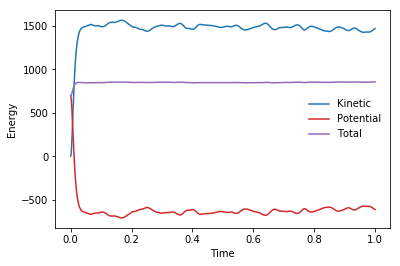

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# -----------------
# Inputs
# -----------------

epsilon = 1
sigma = 1
m = 1
number_density = 0.5
n_dims = 3
box_size = np.array([8,8,8])    # (x, y, z)

delta_t = 0.001        # time between time steps
n_timesteps = 1000     # how many time steps?
dist_cutoff = 3 * sigma

min_dist = 0.8      # minimum distance between particles in initialization

# ----------------
# Calculations: 
# ----------------

## Initialization and determining particle starting locations
n_parts = int(number_density * np.prod(box_size))

init_locs = np.random.rand(n_parts, n_dims) * box_size
min_dists = []
for i in range(n_parts):
    continue_looping = True
    if i == 0:
        continue
    loop_count = 0
    while continue_looping == True:
        if loop_count > 100:
            break
            
        dr = init_locs[i,:] - init_locs[:i,:]
        dr = dr - np.around(dr / box_size) * box_size   # PBC 
        dist = np.sqrt(np.sum(dr**2, axis=1))
        
        if (dist < min_dist).any() == True:
            init_locs[i, :] = np.random.rand(1, n_dims) * box_size
        else:
            continue_looping = False
            min_dists.append(min(dist))
            
        loop_count += 1


## Time Integration

#initialize position and velocity arrays (particles, dimensions, time)
r = np.zeros([n_parts, n_dims, n_timesteps+1])   
r[:, :, 0] = init_locs
v = np.zeros([n_parts, n_dims, n_timesteps+1])
a = np.zeros([n_parts, n_dims])

#total potential, kinetic, and total energies list initialization
Ep = []
Ek = []
E = []

def get_LJ_force_energy(r):
    # r is a 2D array where row i, and col j correspond to particle i and dimension j (x:0, y:1, z:2)
    # outputs a 3D array where f[i,j,:] is the force on i because of j in all dimensions and sum of potential energy
    #             part i    part j  (x,y,z)
    f = np.zeros([n_parts, n_parts, n_dims])
    E_p_sum = 0
    
    for i in range(n_parts):
        # get position vectors and distances between particles 
        r_ij_vect = r[i,:] - r[(i+1):,:]   # vector pointing from j to i
        r_ij_vect -= np.around(r_ij_vect / box_size) * box_size   #pbc
        
        r_ij = np.sqrt(np.sum(r_ij_vect**2, axis=1))

        # get index of particles within range of the spherical cutoff
        parts_in_range = np.where(r_ij <= dist_cutoff)[0]
        r_near = r_ij[parts_in_range]
        
        # Lennard Jones
        # eq 5.3 in Allen and Tildesley 2nd ed
        # fij = -du(rij)/dr * unit vector of r_ij_vect
        f_mag = np.zeros([n_parts-i-1])
        f_mag[parts_in_range] = 24 * epsilon / r_near ** 2 * (2 *
                (sigma/r_near) ** 12 - (sigma/r_near) ** 6)
        
        # new axis converts 1D array to a 2D array 
        f_vect = f_mag[:, np.newaxis] * r_ij_vect/r_ij[:, np.newaxis]
        f[i, (i+1):, :] =  f_vect
        f[(i+1):, i, :] = -f_vect
        
        Ep = np.zeros([n_parts - i - 1])
        Ep[parts_in_range] = 4 * epsilon * ((sigma/r_near) ** 12 - (sigma/r_near) ** 6)
        
        E_p_sum += np.sum(Ep)

    return f, E_p_sum


for k in range(n_timesteps):
    if k == 0:
        # Calculate initial acceleration
        f, pot_energy = get_LJ_force_energy(r[:,:,k])
        Ep.append(pot_energy)
        Ek.append(0)
        E.append(pot_energy)
        f_vect = np.sum(f, axis=1) 
        a_vect = f_vect / m
        
    # using velocity-verlet algorithm
    v_halfdt = v[:,:,k] + 0.5*delta_t * a_vect
    r[:,:,k+1] = r[:,:,k] + delta_t * v_halfdt
    
    # check if out of box and update if so
    r[:,:,k+1] = r[:,:,k+1] - np.floor(r[:,:,k+1] / box_size) * box_size
    
    # update forces and acceleration with new r
    f, pot_energy = get_LJ_force_energy(r[:,:,k+1])
    f_vect = np.sum(f, axis=1) 
    a_vect = f_vect / m
    
    v[:,:,k+1] = v_halfdt + 0.5 * delta_t * a_vect
    
    v_mag = np.sqrt(np.sum(v[:,:,k+1]**2, axis=1))
    KE = np.sum(0.5 * m * v_mag**2)
    Ek.append(KE)
    Ep.append(pot_energy)
    E.append(KE + pot_energy)

## Post Processing
# plot energies
plt.figure()
plt.subplot(111)
x = np.linspace(0, n_timesteps * delta_t, n_timesteps + 1)
plt.plot(x, Ek, label='Kinetic', c='C0')
plt.plot(x, Ep, label='Potential', c='C3')
plt.plot(x, E, label='Total', c='C4')
plt.ylabel('Energy')
plt.xlabel('Time')
plt.legend(frameon=False)
plt.show()

# Box Visualization
If you wish to view what the particles are doing in the code, then run the code below which will animate the results.

<IPython.core.display.Javascript object>


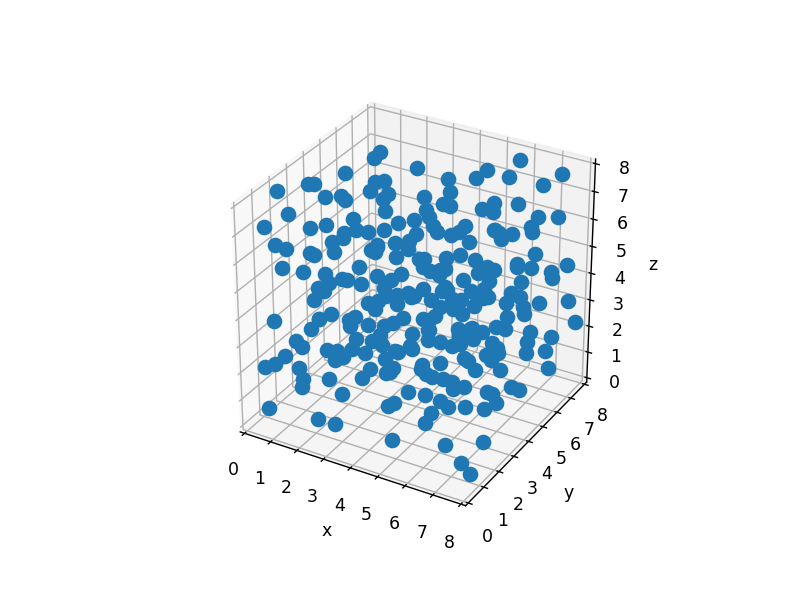

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d([0,box_size[0]])
ax.set_ylim3d([0,box_size[1]])
ax.set_zlim3d([0,box_size[2]])

x = r[:,0,0]
y = r[:,1,0]
z = r[:,2,0]

def update_graph(frame):
    x = r[:,0,frame]
    y = r[:,1,frame]
    z = r[:,2,frame]
    graph.set_data(x,y)
    graph.set_3d_properties(z)
    return graph

graph, = ax.plot(x, y, z, linestyle="", marker="o", ms=8)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, n_timesteps + 1, blit=True, interval=2)
plt.show()